In [1]:
# Pre-process of the image:
# 1) increase contrast and brightness;
# 2) cut it into a square for user's convenience.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
def compute(img, min_percentile, max_percentile):
    # 计算分位点，目的是去掉图1的直方图两头的异常情况
    max_percentile_pixel = np.percentile(img, max_percentile)
    min_percentile_pixel = np.percentile(img, min_percentile)

    return max_percentile_pixel, min_percentile_pixel

In [4]:
def get_lightness(src):
    # 计算亮度
    hsv_image = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
    lightness = hsv_image[:,:,2].mean()
    
    return  lightness

In [5]:
def aug(src):
    # 图像亮度增强
    if get_lightness(src) > 130:
        # 亮度足够，不做增强
        print("Lightness enough")
    # 先计算分位点，去掉像素值中少数异常值，这个分位点可以自己配置。
    # 比如1中直方图的红色在0到255上都有值，但是实际上像素值主要在0到20内。
    max_percentile_pixel, min_percentile_pixel = compute(src, 1, 99)
    
    # 去掉分位值区间之外的值
    src[src >= max_percentile_pixel] = max_percentile_pixel
    src[src <= min_percentile_pixel] = min_percentile_pixel
    
    # 将分位值区间拉伸到0到255，这里取了255*0.1 与 255*0.9,是因为可能会出现像素值溢出的情况，所以最好不要设置为0到255。
    out = np.zeros(src.shape, src.dtype)
    cv2.normalize(src, out, 255*0.1, 255*0.9, cv2.NORM_MINMAX)
    
    return out

In [6]:
# img input
img = cv2.imread(r"/Users/yixuangao/dsa3101-2210/test.png")

In [7]:
# 将img通过 aug() 进行处理, 并save as "out.png".
img = aug(img)
cv2.imwrite('out.png', img)

Lightness enough


True

In [8]:
# from PIL import Image
# from IPython.display import Image as IMG
# path = "/Users/yixuangao/dsa3101-2210/test.png"

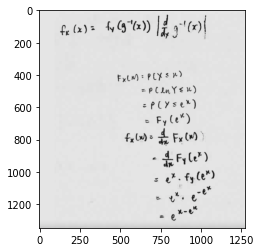

In [10]:
# plot处理后的img
plt.imshow(img)
plt.show()

In [11]:
# 增强对比度

In [12]:
# 想要把处理过的image--"out"作为input，但是怎么才能不需要手动设置input呢？
# out = cv2.imread(r"/Users/yixuangao/dsa3101-2210/out.png")

In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


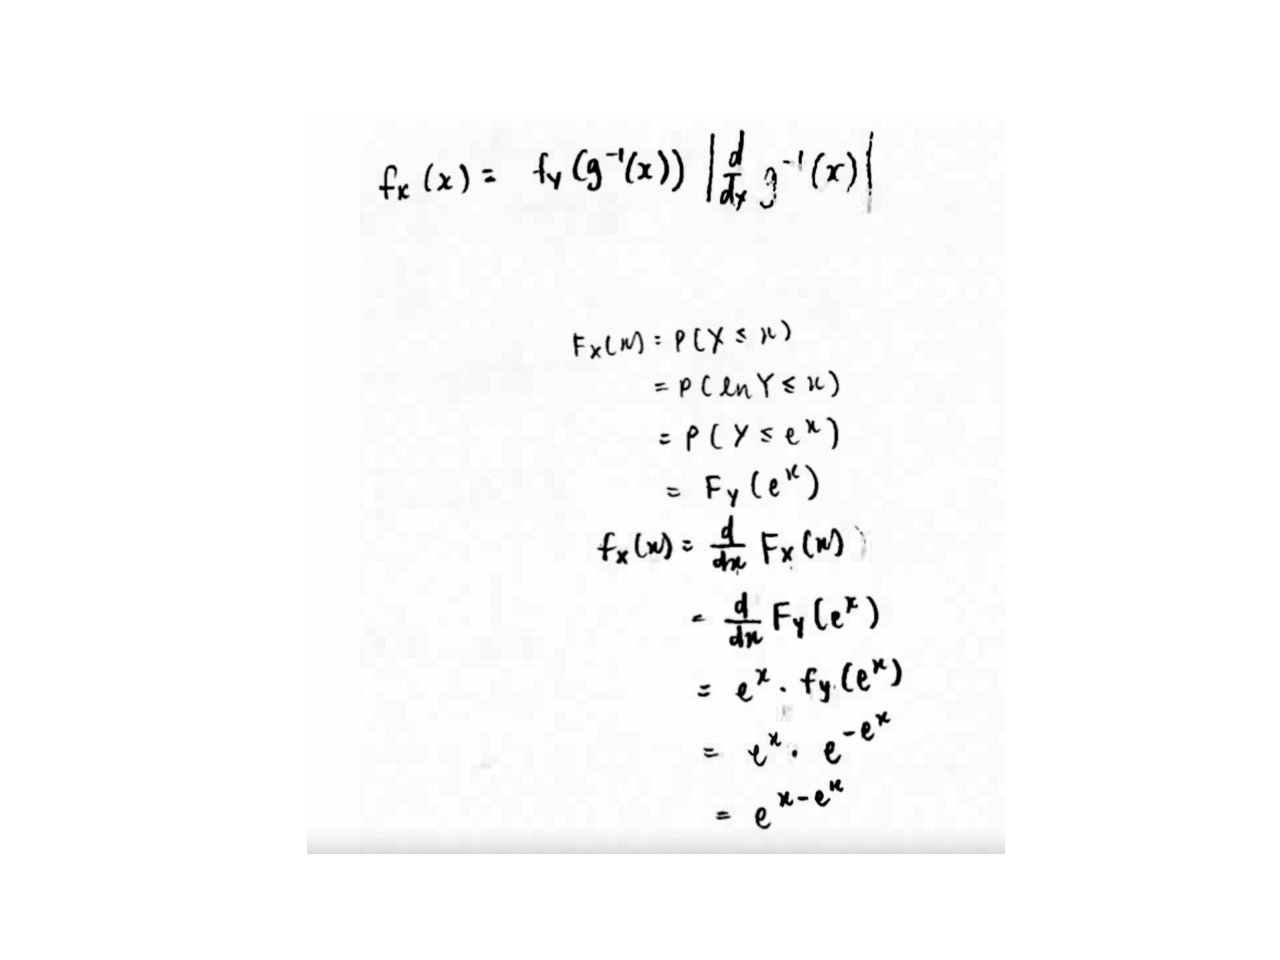

In [14]:
out_min=0
out_max=255

in_min = np.min(img) #原图最小像素值
in_max = np.max(img) #原图最大像素值

a = float(out_max-out_min)/(in_max-in_min)
b = out_min-a*in_min
img_norm = img*a+b   #正规化原理公式
img_norm = img_norm.astype(np.uint8)
plt.axis('off')
plt.imshow(img_norm)
plt.show()

In [18]:
# save plot with high quality, without axis.
plt.savefig('img_norm.png', bbox_inches='tight', dpi = 300)

In [ ]:
# 好像可以用eps格式 to get good figures in a LaTeX document. 但不知道有什么用
# https://stackoverflow.com/questions/16183462/saving-images-in-python-at-a-very-high-quality


In [20]:
from os.path import basename
from glob import glob

In [21]:
def get_contours(img):
    # First make the image 1-bit and get contours
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 150, 255, 0)
    cv2.imwrite('thresh.jpg', thresh)
    img2, contours, hierarchy = cv2.findContours(thresh, 1, 2)
    
    # filter contours that are too large or small
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

In [22]:
def get_size(img):
    ih, iw = img.shape[:2]
    return iw * ih

In [23]:
def contourOK(cc, size=1000000):
    x, y, w, h = cv2.boundingRect(cc)
    if w < 50 or h < 50: 
        return False # too narrow or wide is bad
    area = cv2.contourArea(cc)
    return area < (size * 0.5) and area > 200

In [24]:
def find_boundaries(img, contours):
# margin is the minimum distance from the edges of the image, as a fraction
    ih, iw = img.shape[:2]
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0
    for cc in contours:
        x, y, w, h = cv2.boundingRect(cc)
        if x < minx: 
            minx = x
        if y < miny: 
            miny = y
        if x + w > maxx: 
            maxx = x + w
        if y + h > maxy: 
            maxy = y + h
    return (minx, miny, maxx, maxy)

In [25]:
def crop(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]

In [30]:
def process_image(fname):
    img = cv2.imread(fname)
    contours = get_contours(img)
    #cv2.drawContours(img, contours, -1, (0,255,0)) # draws contours, good for debugging
    bounds = find_boundaries(img, contours)
    cropped = crop(img, bounds)
    if get_size(cropped) < 400: 
        return # too small
    cv2.imwrite('cropped/' + basename(fname), cropped)

In [28]:
process_image('img_norm.png')

ValueError: not enough values to unpack (expected 3, got 2)